In [1]:
# Imports
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
from matplotlib import cm, colors
from matplotlib.colors import LinearSegmentedColormap
import sys
sys.path.append('/home/563/rl5183/Documents/CSIRO')
import categorical_enso_functions as func
from dask.distributed import wait
from scipy.stats import pearsonr
import xesmf
import cf_xarray
import seaborn as sns

In [2]:
# Dask client 
from dask.distributed import Client
client = Client(memory_limit=None, threads_per_worker=1)#(memory_limit=None, n_cpus=15≈1)
client.cluster.scale(8) 
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 8
Total threads: 8,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40363,Workers: 8
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:33929,Total threads: 1
Dashboard: /proxy/44439/status,Memory: 0 B
Nanny: tcp://127.0.0.1:36617,


2025-04-02 11:47:41,975 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 25af7e6eec50a7630075ff2666c20675 initialized by task ('rechunk-merge-rechunk-transfer-a2839c6a5321160311fb04f15df1c006', 0, 0, 0, 0, 0, 0, 0, 3) executed on worker tcp://127.0.0.1:44673
2025-04-02 11:47:54,833 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 25af7e6eec50a7630075ff2666c20675 deactivated due to stimulus 'task-finished-1743554874.8308697'
2025-04-02 12:11:20,298 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c34e6bb5d8cecf5ff5c88c2e32d80d39 initialized by task ('rechunk-merge-rechunk-transfer-f5a2de901317b05635e47b8830f74d05', 0, 0, 0, 0, 0, 0, 0, 4) executed on worker tcp://127.0.0.1:46619
2025-04-02 12:11:20,893 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle c34e6bb5d8cecf5ff5c88c2e32d80d39 deactivated due to stimulus 'task-finished-1743556280.8910797'
2025-04-02 12:20:44,821 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 87e7cb21444ad29b

In [3]:
# Silence warnings 
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

In [63]:
# Load in HADISST data 
hadisst = xr.open_dataset('/g/data/w40/rl5183/OBS/hadisst.1870_2017_1.5x1.5.nc').sst.sel(time=slice('1981-01','2018-12'))
hadisst_son = hadisst.sel(time=hadisst.time.dt.season == "SON").groupby("time.year").mean("time")
nino34_had = nino34_index(hadisst_son)

#### ACCESS-S2 Lag 0

In [24]:
ds_ensemble1 = func.read_access_lag0("/g/data/ux62/access-s2/hindcast/raw_model/atmos/ts/monthly/e01/ma_ts_{}_e01.nc").persist()
wait(ds_ensemble1);
ds_ensemble2 = func.read_access_lag0("/g/data/ux62/access-s2/hindcast/raw_model/atmos/ts/monthly/e02/ma_ts_{}_e02.nc").persist()
wait(ds_ensemble2);
ds_ensemble3 = func.read_access_lag0("/g/data/ux62/access-s2/hindcast/raw_model/atmos/ts/monthly/e03/ma_ts_{}_e03.nc").persist()
wait(ds_ensemble3);

In [29]:
# Combine e1, e2, and e3
ds_combined = xr.concat([ds_ensemble1, ds_ensemble2, ds_ensemble3], dim="ensemble")

# Chunk
ds_combined = ds_combined.chunk({"year": -1, "lat": 150, "lon": 200, "ensemble": -1})

# Persist
ds_combined = ds_combined.persist()
wait(ds_combined)

# Assign new ensemble numbers from 1 to 27
ds_combined = ds_combined.assign_coords(ensemble=np.arange(1, 28))

In [31]:
def nino34_index(sst):
    nino34_region = sst.sel(lat=slice(-5,5), lon=slice(190,240)) #may need to alter this depending on dataset
    climatology = nino34_region.mean()
    nino34_index = (nino34_region-climatology).mean(dim=['lat','lon'])
    return nino34_index

In [34]:
# Calculate Niño34
nino34_list = []
for ens in ds_combined.ensemble:
    nino34_list.append(nino34_index(ds_combined.sel(ensemble=ens)))

In [39]:
# Make xarray dataarray 
nino34 = xr.DataArray(nino34_list, dims=['ensemble', 'year'], coords=[ds_combined.ensemble, ds_combined.year])

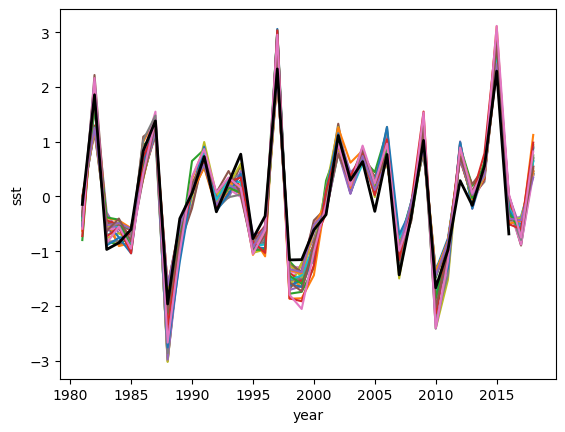

In [66]:
# Plot NINO34 for each ensemble member 
for ens in nino34.ensemble:
    nino34.sel(ensemble=ens).plot()
nino34_had.plot(color='black', linewidth=2)

#### Lag 3

In [46]:
ds_ensemble1 = func.read_access_lag3("/g/data/ux62/access-s2/hindcast/raw_model/atmos/ts/monthly/e01/ma_ts_{}_e01.nc").persist()
wait(ds_ensemble1);
ds_ensemble2 = func.read_access_lag3("/g/data/ux62/access-s2/hindcast/raw_model/atmos/ts/monthly/e02/ma_ts_{}_e02.nc").persist()
wait(ds_ensemble2);
ds_ensemble3 = func.read_access_lag3("/g/data/ux62/access-s2/hindcast/raw_model/atmos/ts/monthly/e03/ma_ts_{}_e03.nc").persist()
wait(ds_ensemble3);

In [47]:
# Combine e1, e2, and e3
ds_combined = xr.concat([ds_ensemble1, ds_ensemble2, ds_ensemble3], dim="ensemble")

# Chunk
ds_combined = ds_combined.chunk({"year": -1, "lat": 150, "lon": 200, "ensemble": -1})

# persist
ds_combined = ds_combined.persist()
wait(ds_combined);

# Assign new ensemble numbers from 1 to 27
ds_combined = ds_combined.assign_coords(ensemble=np.arange(1, 28))

In [48]:
# Calculate Niño34
nino34_list = []
for ens in ds_combined.ensemble:
    nino34_list.append(nino34_index(ds_combined.sel(ensemble=ens)))

nino34_lag3 = xr.DataArray(nino34_list, dims=['ensemble', 'year'], coords=[ds_combined.ensemble, ds_combined.year])

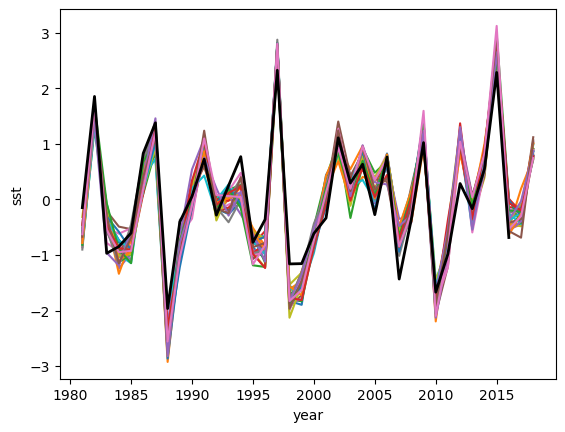

In [65]:
# Plot NINO34 for each ensemble member 
for ens in nino34_lag3.ensemble:
    nino34_lag3.sel(ensemble=ens).plot()
nino34_had.plot(color='black', linewidth=2)

#### Lag 9 

In [51]:
ds_ensemble1 = func.read_access_lag9("/g/data/ux62/access-s2/hindcast/raw_model/atmos/ts/monthly/e01/ma_ts_{}_e01.nc").persist()
wait(ds_ensemble1);
ds_ensemble2 = func.read_access_lag9("/g/data/ux62/access-s2/hindcast/raw_model/atmos/ts/monthly/e02/ma_ts_{}_e02.nc").persist()
wait(ds_ensemble2);
ds_ensemble3 = func.read_access_lag9("/g/data/ux62/access-s2/hindcast/raw_model/atmos/ts/monthly/e03/ma_ts_{}_e03.nc").persist()
wait(ds_ensemble3);

In [52]:
# Combine e1, e2, and e3
ds_combined = xr.concat([ds_ensemble1, ds_ensemble2, ds_ensemble3], dim="ensemble")

# Chunk
ds_combined = ds_combined.chunk({"year": -1, "lat": 150, "lon": 200, "ensemble": -1})

# persist
ds_combined = ds_combined.persist()
wait(ds_combined);

# Assign new ensemble numbers from 1 to 27
ds_combined = ds_combined.assign_coords(ensemble=np.arange(1, 28))

In [53]:
# Calculate Niño34
nino34_list = []
for ens in ds_combined.ensemble:
    nino34_list.append(nino34_index(ds_combined.sel(ensemble=ens)))

nino34_lag9 = xr.DataArray(nino34_list, dims=['ensemble', 'year'], coords=[ds_combined.ensemble, ds_combined.year])

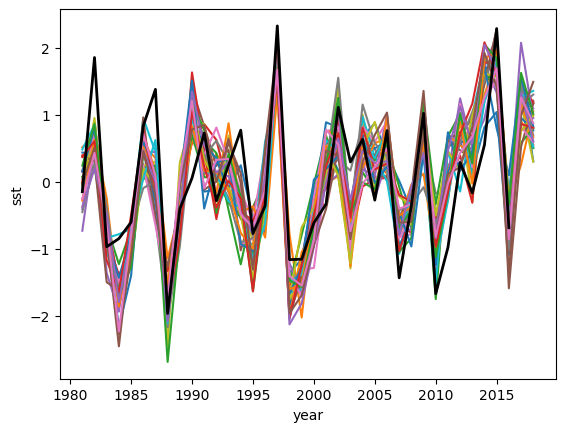

In [64]:
# Plot NINO34 for each ensemble member 
for ens in nino34_lag9.ensemble:
    nino34_lag9.sel(ensemble=ens).plot()
nino34_had.plot(color='black', linewidth=2)

#### Correlations

In [73]:
cor0 = []
cor3 = []
cor9 = []
for ens in nino34.ensemble:
    cor0.append(pearsonr(nino34_had, nino34.sel(year=nino34_had.year).sel(ensemble=ens))[0])
    cor3.append(pearsonr(nino34_had, nino34_lag3.sel(year=nino34_had.year).sel(ensemble=ens))[0])
    cor9.append(pearsonr(nino34_had, nino34_lag9.sel(year=nino34_had.year).sel(ensemble=ens))[0])

<Axes: >

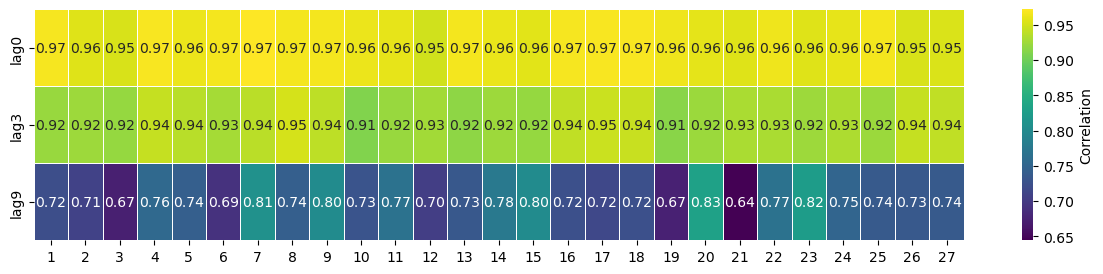

In [75]:
data = np.array([cor0, cor3, cor9])
plt.figure(figsize=(15, 3))  
sns.heatmap(data, annot=True, fmt=".2f", cmap="viridis", cbar=True, 
            xticklabels=np.arange(1, 28), yticklabels=["lag0", "lag3", "lag9"], 
            cbar_kws={'label': 'Correlation'}, linewidths=0.5)

In [77]:
client.close()